#  Sales Forecasting Dashboard
This notebook demonstrates sales forecasting using **ARIMA** and **LSTM** models.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")


In [2]:

# Generate 2 years of daily sales data
date_rng = pd.date_range(start="2023-01-01", end="2024-12-31", freq="D")
np.random.seed(42)
sales = np.random.randint(100, 500, size=(len(date_rng))) + np.sin(np.arange(len(date_rng)) / 20) * 50

df = pd.DataFrame(date_rng, columns=["date"])
df["sales"] = sales

df.head()


,date,sales
0,2023-01-01,202.000000
1,2023-01-02,450.498958
2,2023-01-03,374.991671
3,2023-01-04,213.471907
4,2023-01-05,180.933467


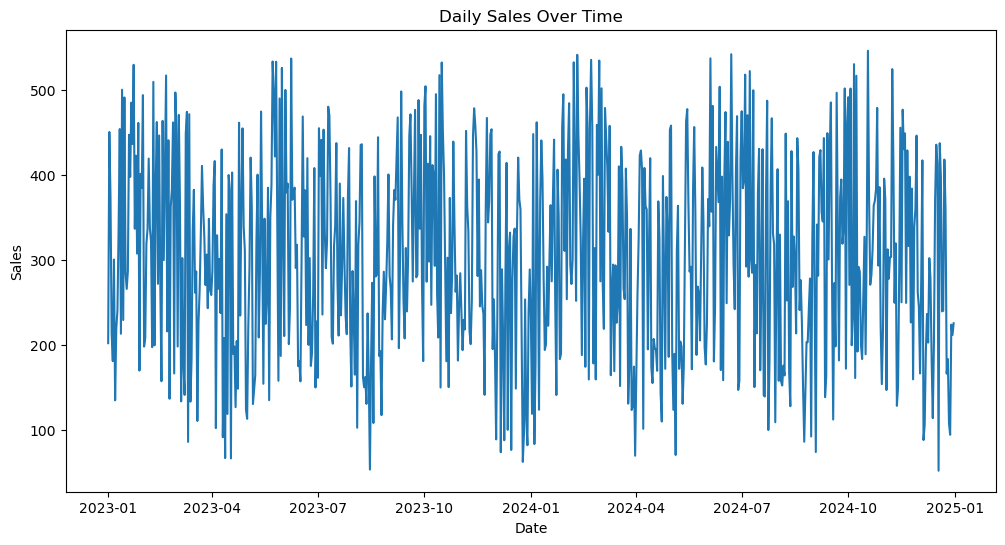

In [3]:

plt.figure(figsize=(12,6))
sns.lineplot(x="date", y="sales", data=df)
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


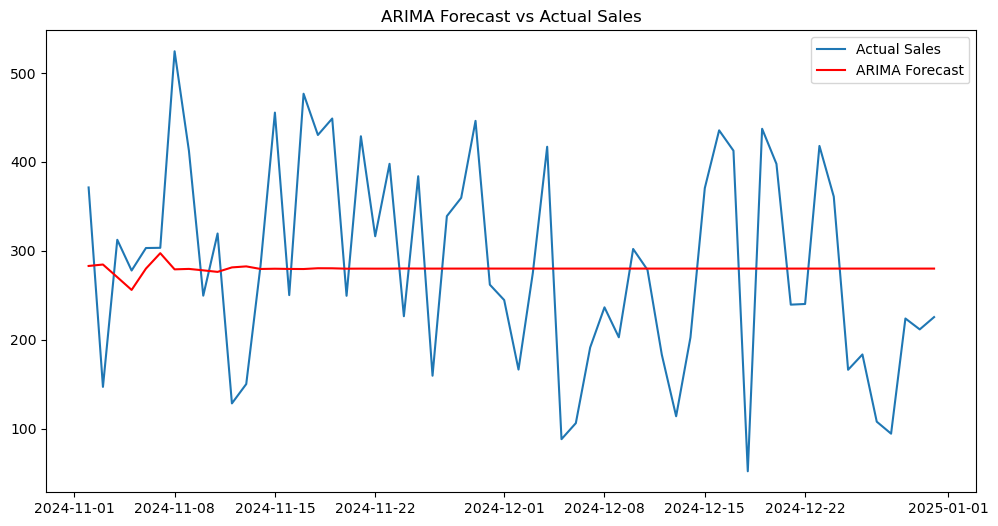

In [4]:

# Use ARIMA for forecasting
train = df["sales"][:-60]
test = df["sales"][-60:]

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=60)

plt.figure(figsize=(12,6))
plt.plot(df["date"][-60:], test, label="Actual Sales")
plt.plot(df["date"][-60:], forecast, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("ARIMA Forecast vs Actual Sales")
plt.show()


In [5]:

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df["sales"].values.reshape(-1,1))

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=3, batch_size=32)


Epoch 1/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1053
Epoch 2/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0572
Epoch 3/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0561


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


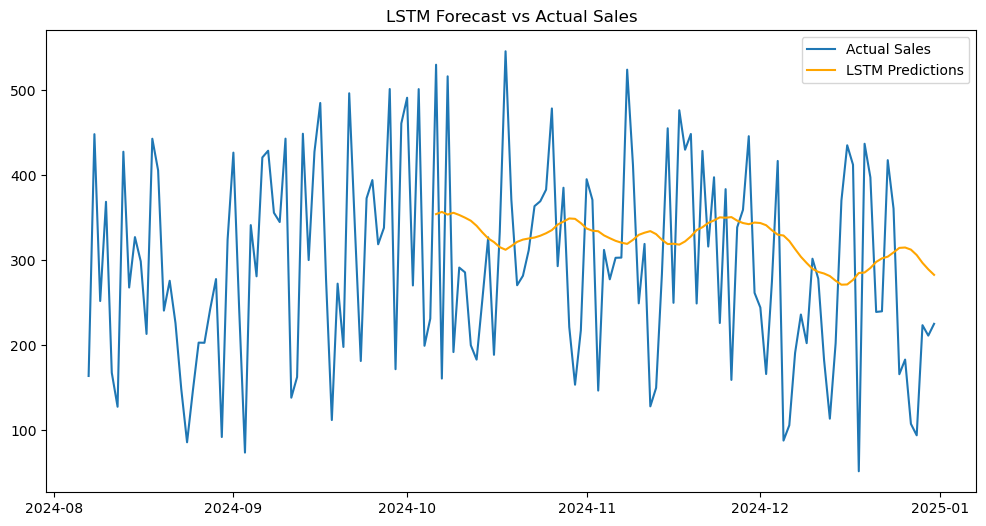

In [6]:

# Prepare test data
X_test, y_test = [], df["sales"][train_size:]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot Results
plt.figure(figsize=(12,6))
plt.plot(df["date"][train_size:], y_test, label="Actual Sales")
plt.plot(df["date"][train_size+60:], predictions, label="LSTM Predictions", color="orange")
plt.legend()
plt.title("LSTM Forecast vs Actual Sales")
plt.show()
